# Numerical solution of the Fokker-Planck Equation

In [1]:
import matplotlib.pyplot as plt
import numpy as np

#### The Fokker Planck equation for the phase space probability distribution of the noisy van der Pol oscillator reads
$$
\frac{\partial w(\xi_i,t)}{\partial t}=-\frac{\partial}{\partial\xi_i}D_iw(\xi_i,t)+\frac{1}{2}
\frac{\partial^2 }{\partial\xi_i\partial\xi_j}D_{ij}w(\xi_i,t)
$$
with the vector $\mathbf{\xi}=(x,v)^T$ and
\begin{align}
D_x^{(1)}&=v\\
D_v^{(1)}&=(2-x^2)v-x\\
D_{vv}^{(1)}&=g\\
\end{align}
where the nonliearity $(2-x^2)v$ was taken form Gradisek, J et. al PRE 62, 3146

In [10]:
# 1st derivative w.r.t. x
def dwdx(m):
    return (np.roll(m,shift=(0,-1),axis=(0,1))-np.roll(m,shift=(0,1),axis=(0,1)))/2.
# 1st central derivative w.r.t. v
def dwdv(m):
    return (np.roll(m,shift=(-1,0),axis=(0,1))-np.roll(m,shift=(1,0),axis=(0,1)))/2.
# 2nd derivative w.r.t. v
def d2wdv2(m):
    return np.roll(m,shift=(0,-1),axis=(0,1))-2.0*m+np.roll(m,shift=(0,1),axis=(0,1))

#### In the case of a van der Pol oscillator we have
$$
\frac{\partial w(x,v,t)}{\partial t}=-(2-x^2)w(x,v,t)-v\frac{\partial w(x,v,t)}{\partial x}+
(x-(2-x^2)v)\frac{\partial w(x,v,t)}{\partial v}+
g\frac{\partial^2 w(x,v,t)}{\partial v^2}
$$
In terms of finite differences with Euler forward we have
$$
w(x,v,t+\Delta t)=
(1-(2-x^2)\Delta t)\cdot w(x,v,t)
-v\frac{w(x+\Delta x,v,t)-w(x-\Delta x,v,t)}{2\Delta x}\Delta t
+(x-(2-x^2)v)\frac{w(x,v+\Delta v,t)-w(x,v-\Delta v,t)}{2\Delta v} \Delta t
+g\frac{w(x,v+\Delta v,t)-2\cdot w(x,v,t)+w(x,v-\Delta v,t)}{\Delta v^2}\Delta t
$$

In [11]:
x,v=np.meshgrid(np.linspace(-1000,1000,2001),np.linspace(-1000,1000,2001))
wxv=np.zeros((2001,2001))
wxv[1101:1151,1101:1151]=1.0
plt.imshow(wxv)

In [12]:
dt=.00001 # timestep
c=3.0    # diffusion constant
#
xsq=x*x
xsqv=x*x*v
#
for i in np.arange(100):
    wxv[1:-2,1:-2]=(wxv-(2-xsq)*wxv*dt
                    -v*dwdx(wxv)*dt
                    +(x-2*v+xsqv)*dwdv(wxv)*dt
                    +c*d2wdv2(wxv)*dt/2.)[1:-2,1:-2]
plt.imshow(wxv)

In [14]:
# Back to the oszillator
dt=.0005 # timestep
c=1.0    # diffusion constant
#
x,v=np.meshgrid(np.linspace(-1000,1000,2001),np.linspace(-1000,1000,2001))
wxv=np.zeros((2001,2001))
wxv[1101:1151,1101:1151]=1.0
#
for i in np.arange(100):
    wxv[1:-2,1:-2]=(wxv
                    -v*dwdx(wxv)*dt
                    +x*dwdv(wxv)*dt
                    +c*d2wdv2(wxv)*dt/2.)[1:-2,1:-2]
plt.imshow(wxv)

<IPython.core.display.Javascript object>


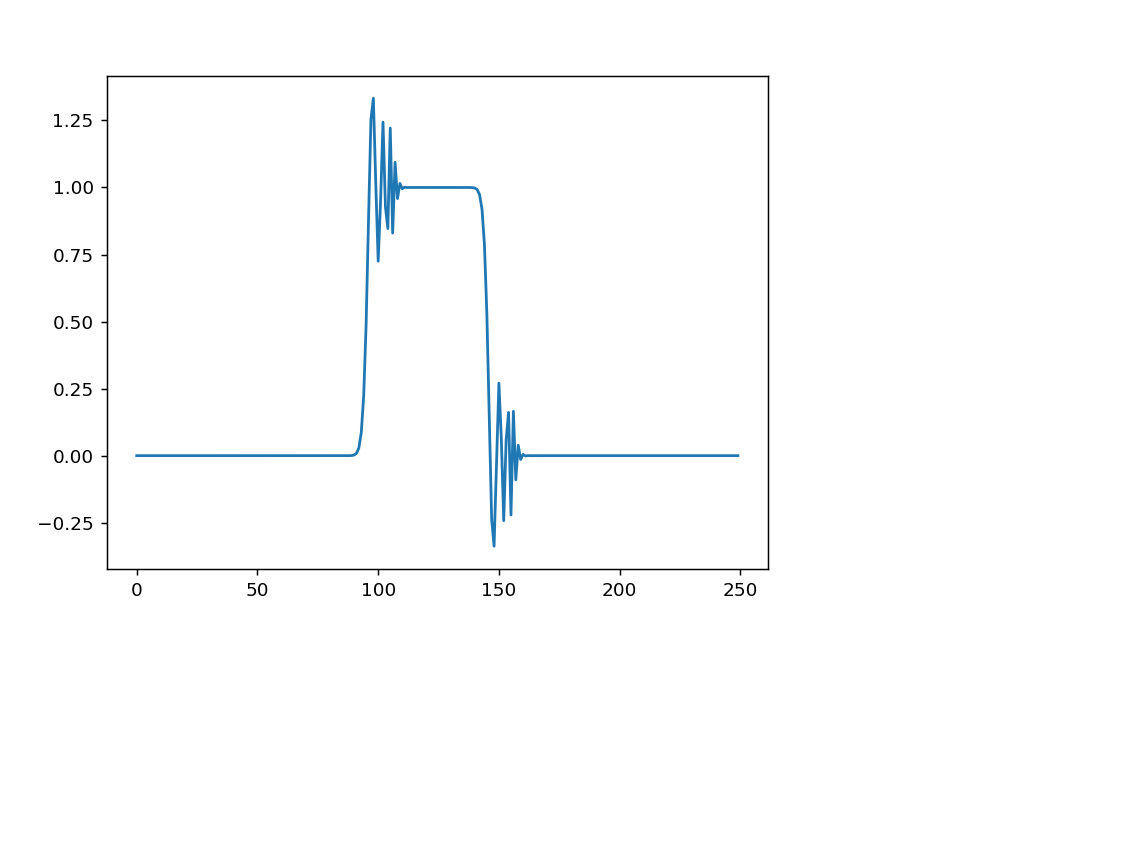

In [15]:
%matplotlib notebook
plt.plot(wxv[1000:1250,1125])

In [ ]:
a=np.array(np.arange(9)).reshape((3,3))

In [ ]:
np.roll(a,shift=(1,1),axis=(0,1))

In [ ]:
a

In [ ]:
a[0,1]

In [ ]:
x[0]